# Supervised machine learning pipeline for sepsis diagnosis using vital signs, laboratory tests and demographic variables

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

In [3]:
import matplotlib.pyplot as plt

Importing data PatientTimeSeries.csv into a pandas dataframe

In [4]:
data = pd.read_csv("PatientTimeSeries.csv")

In [5]:
data.head()

,Patient_id,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
0,p116812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,59.0,1,-6.01,1,0
1,p116812,102.0,100.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,59.0,1,-6.01,2,0
2,p116812,102.0,100.0,NaN,99.0,84.0,76.0,18.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,59.0,1,-6.01,3,0
3,p116812,124.0,100.0,NaN,97.0,70.0,55.0,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,59.0,1,-6.01,4,0
4,p116812,98.0,100.0,NaN,95.0,73.0,62.0,18.0,NaN,NaN,...,7.5,NaN,6.8,NaN,276.0,59.0,1,-6.01,5,0


In [6]:
data.columns

Index(['Patient_id', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST',
       'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS',
       'SepsisLabel'],
      dtype='object')

Visualization: Boxplots of all features to spot any nonsensical values

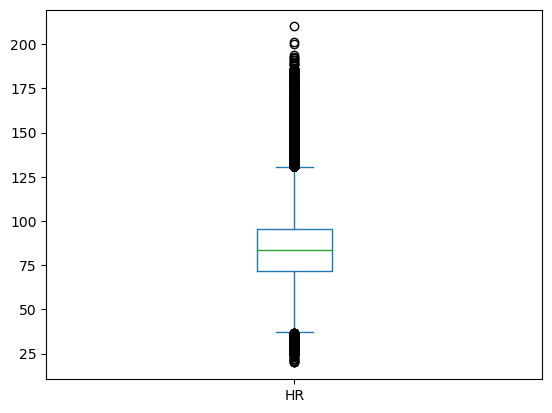

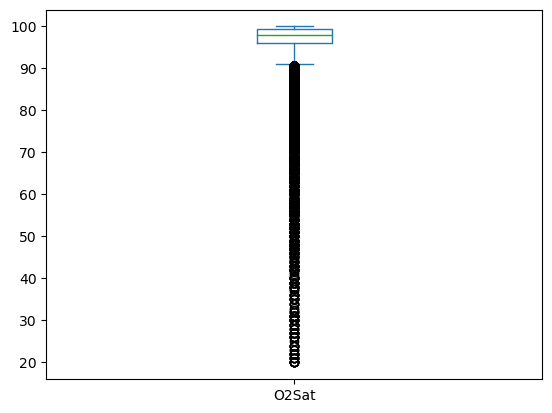

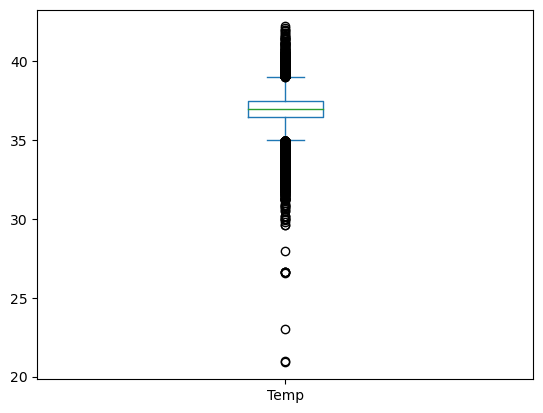

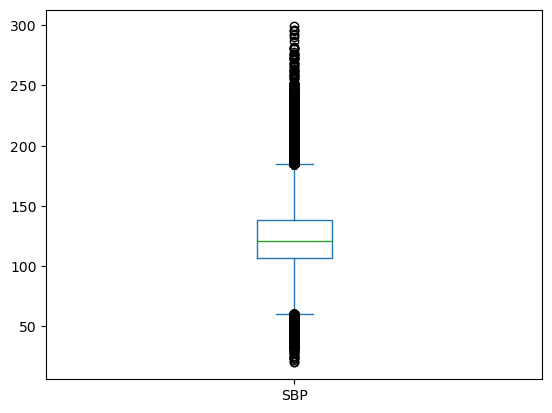

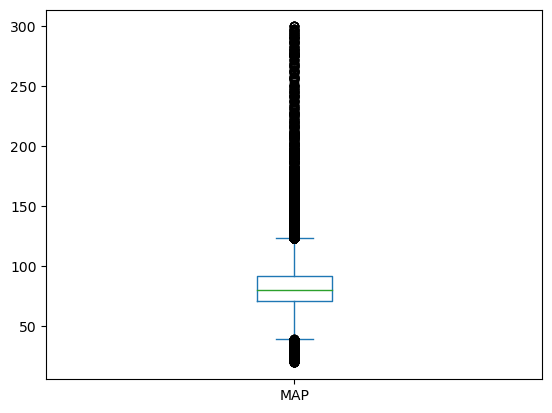

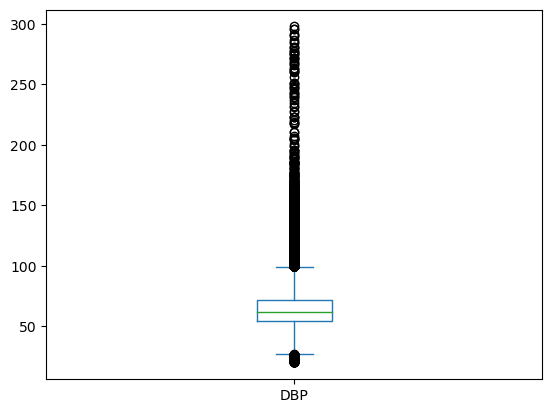

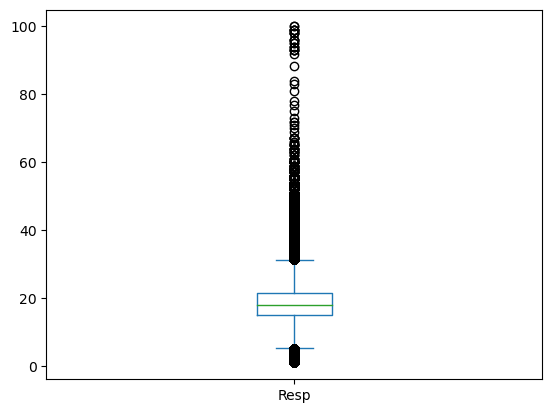

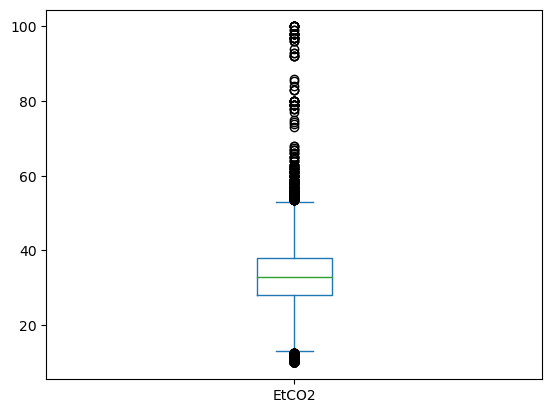

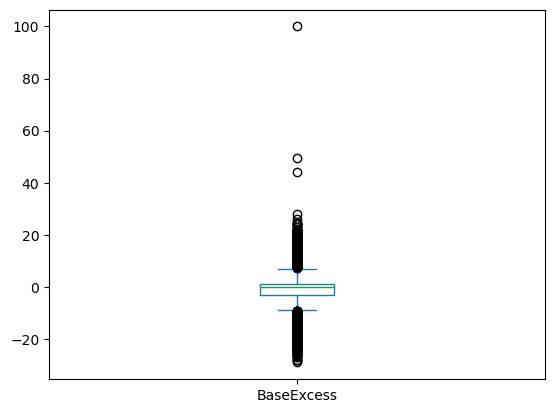

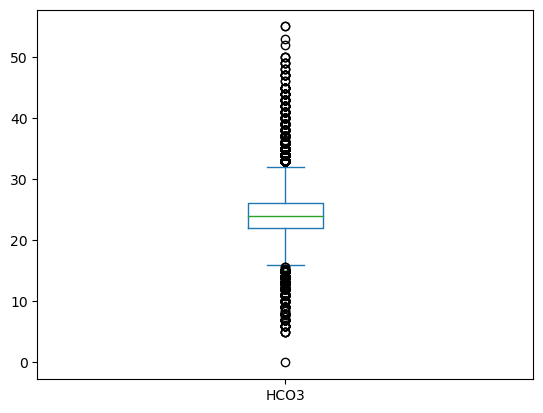

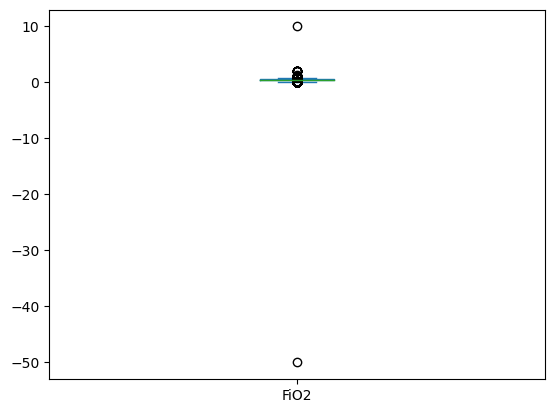

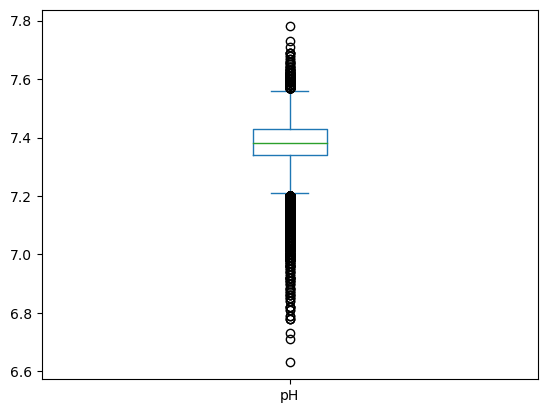

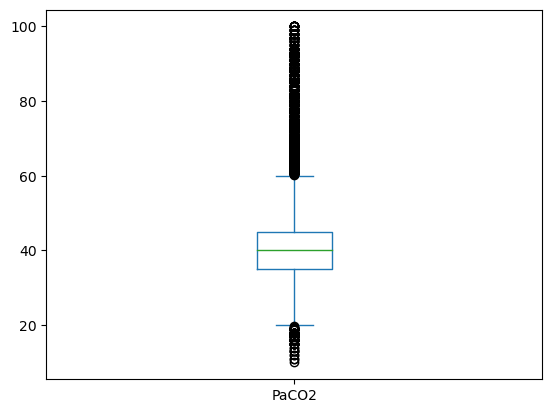

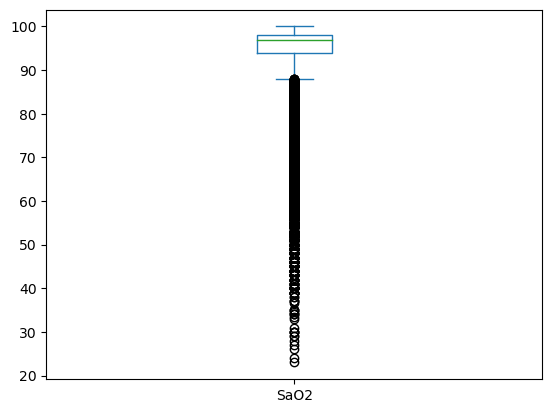

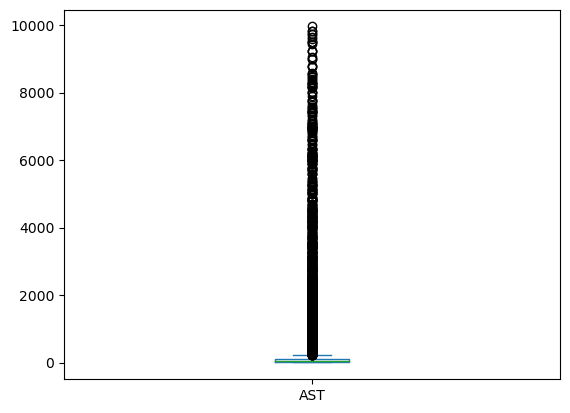

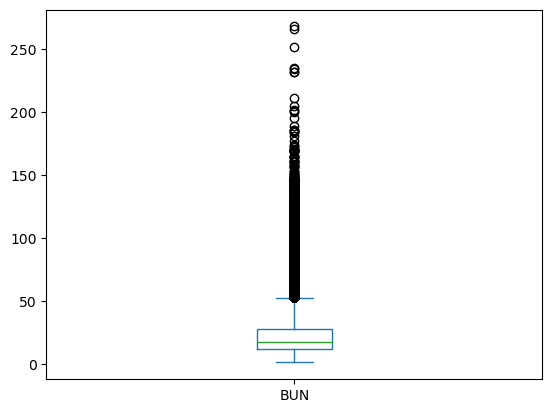

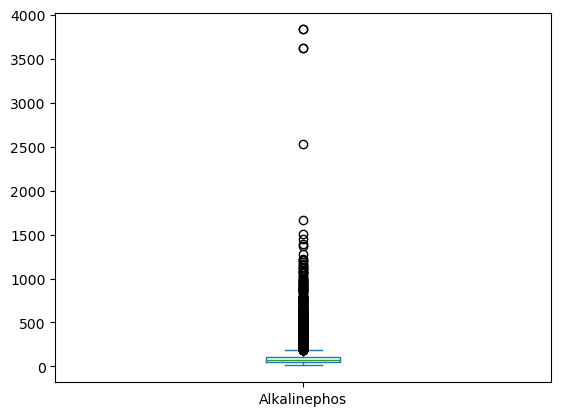

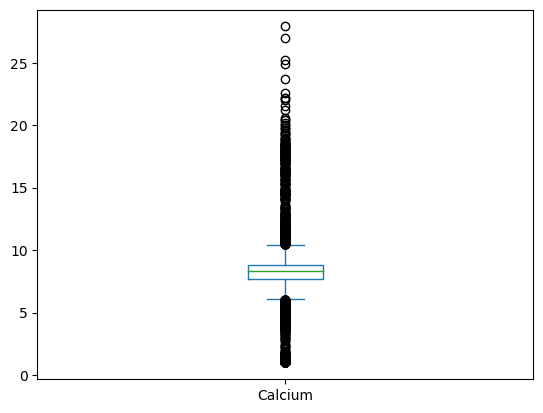

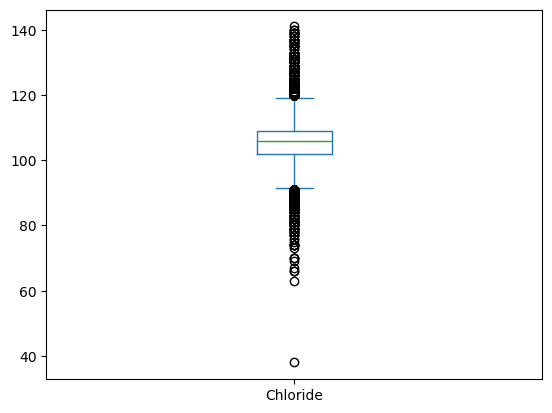

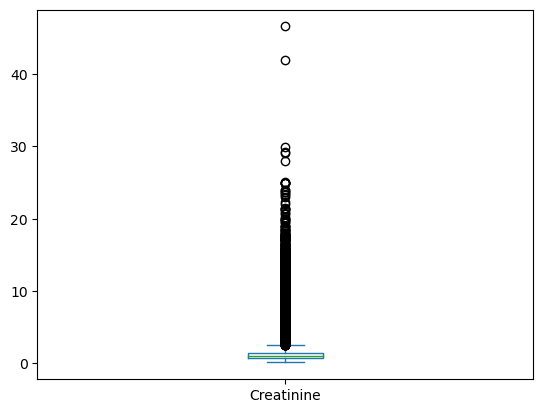

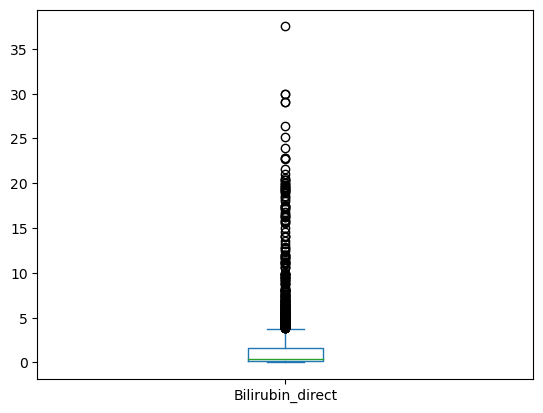

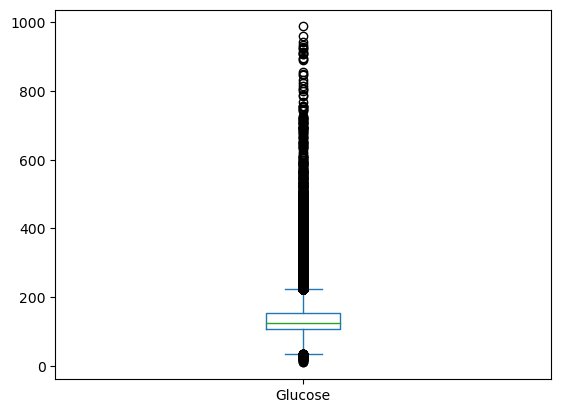

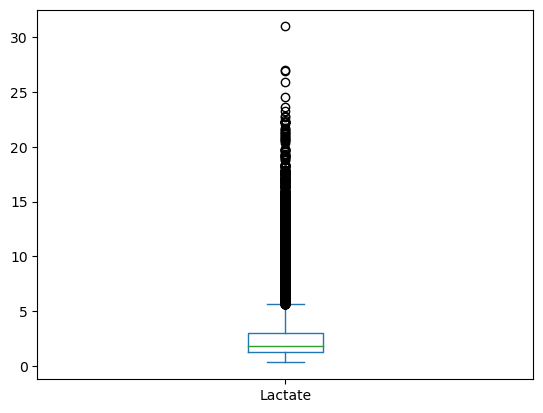

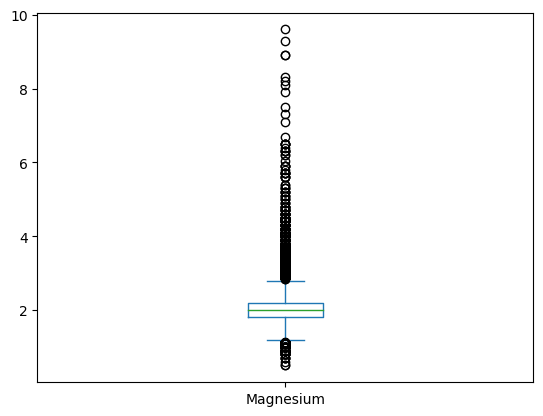

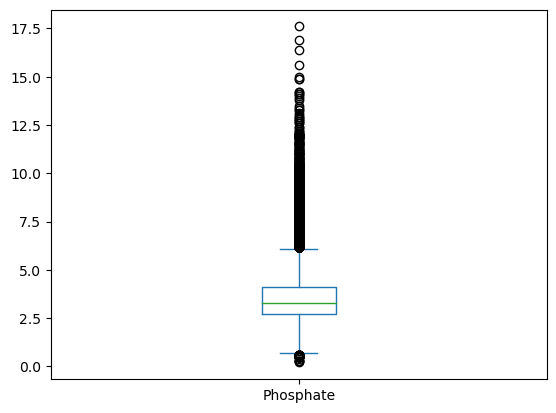

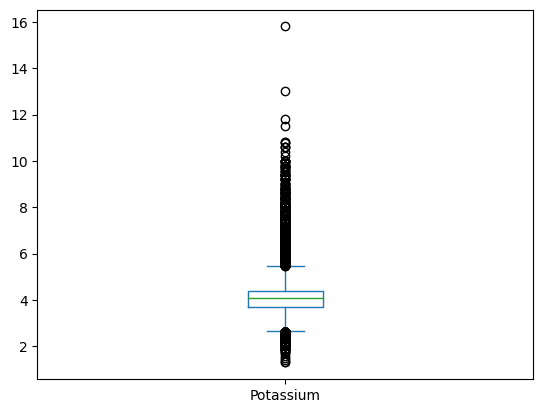

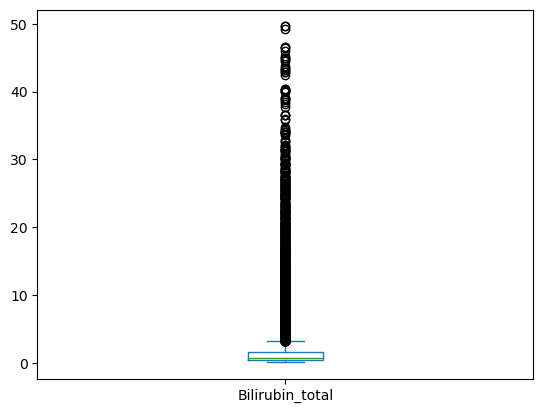

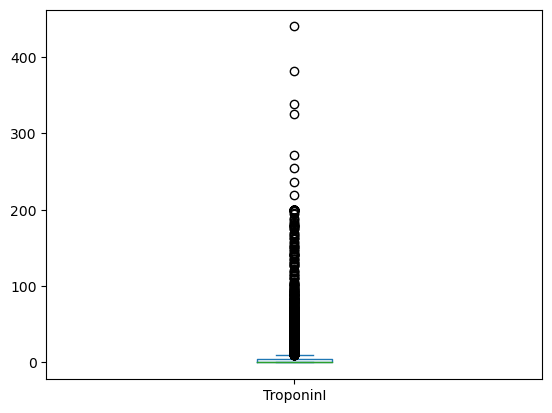

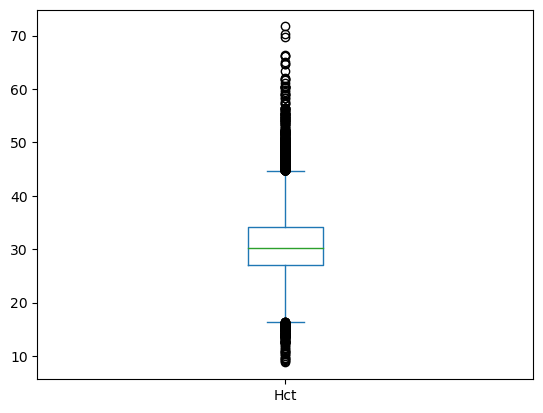

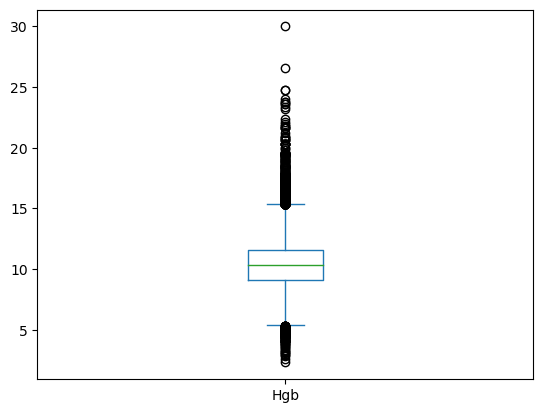

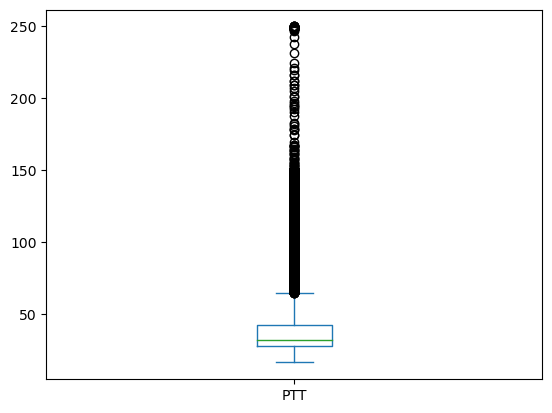

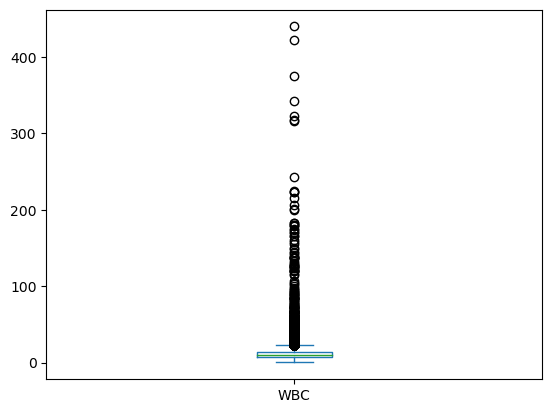

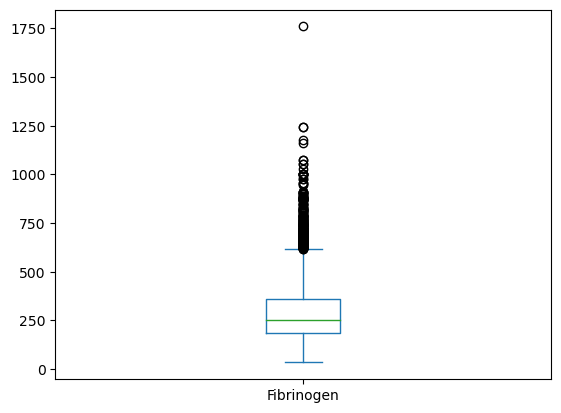

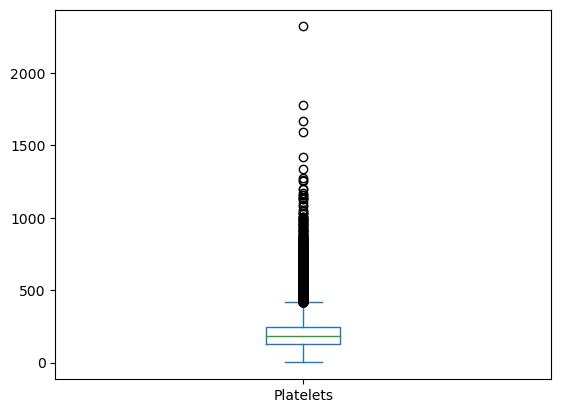

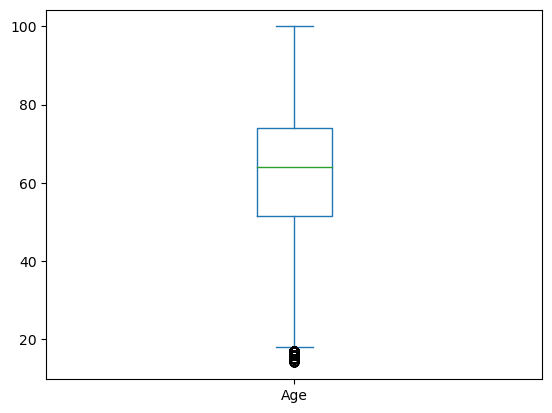

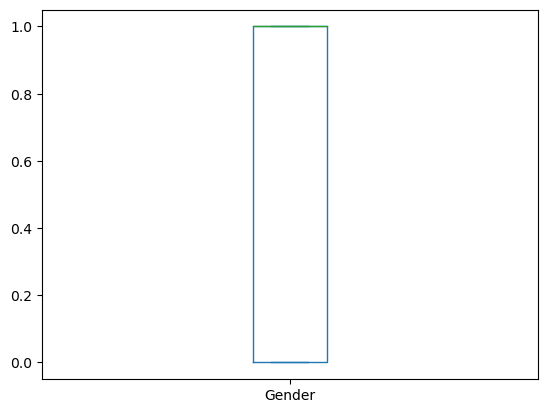

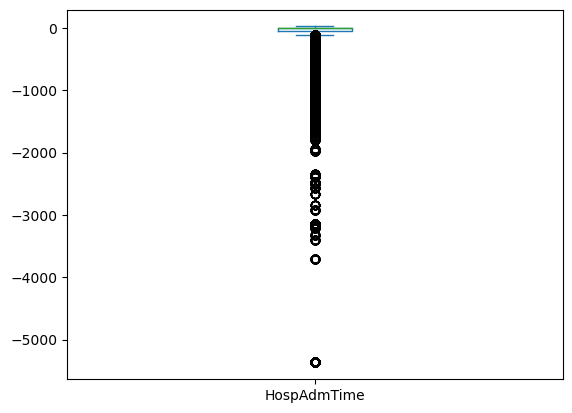

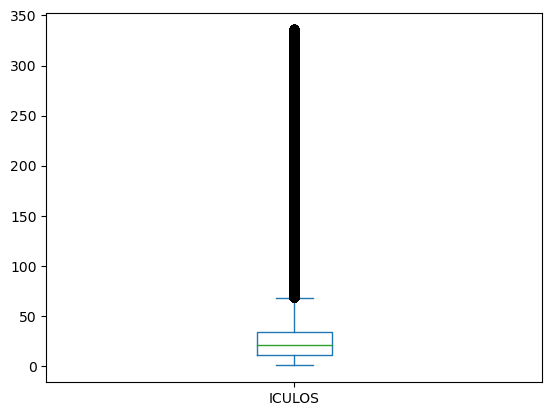

In [7]:
list_to_plot = list(range(1,39))
for i in list_to_plot:
    data.iloc[:,i].plot(kind='box')
    plt.show()

FiO2 is a fraction and percentage. The zeros in FiO2 should be replaced with Nan, as it is likely that the value is zero because the actual value is missing (value is a percentage and can’t be zero). Negative values and values greater than 1 should be replaced with the mean of FiO2 (percentage can’t be negative and it is a fraction so greater than 1 seems erroneous). There are few other values like in Alkalinephos and fibrinogen which are unexceptionally high, but we can't treat them as outliers. They could indicative of the patient's severe condition.

In [8]:
data['FiO2'] = data['FiO2'].replace(0, np.nan)

In [9]:
data.head()

,Patient_id,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
0,p116812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,59.0,1,-6.01,1,0
1,p116812,102.0,100.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,59.0,1,-6.01,2,0
2,p116812,102.0,100.0,NaN,99.0,84.0,76.0,18.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,59.0,1,-6.01,3,0
3,p116812,124.0,100.0,NaN,97.0,70.0,55.0,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,59.0,1,-6.01,4,0
4,p116812,98.0,100.0,NaN,95.0,73.0,62.0,18.0,NaN,NaN,...,7.5,NaN,6.8,NaN,276.0,59.0,1,-6.01,5,0


In [10]:
data.loc[(data['FiO2'] < 0) | (data['FiO2'] > 1), 'FiO2'] = data.FiO2.mean()

Plot boxplot again for FiO2 to check if the nonsensical values are replaced

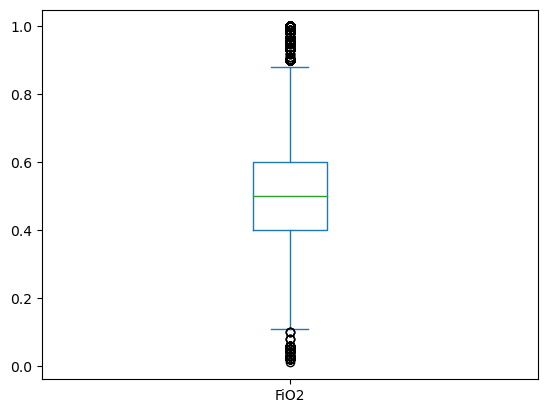

In [11]:
data.iloc[:,11].plot(kind='box')
plt.show()

In [12]:
data.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
count,945030.000000,911165.000000,351898.000000,896310.000000,918122.000000,721427.000000,887150.000000,38404.000000,57094.000000,43994.000000,...,77254.000000,30944.000000,67082.000000,6789.000000,61992.000000,1.048575e+06,1.048575e+06,1.048567e+06,1.048575e+06,1.048575e+06
mean,84.572025,97.193494,36.974508,123.765946,82.403395,63.829379,18.725505,32.900036,-0.684051,24.063483,...,10.425548,41.245061,11.498152,291.217631,197.033750,6.196167e+01,5.604330e-01,-5.678107e+01,2.702792e+01,1.805307e-02
std,17.317288,2.948553,0.767656,23.256676,16.341789,13.961511,5.081630,8.022458,4.273337,4.322053,...,1.966090,26.345071,8.014632,153.929954,104.432275,1.641458e+01,4.963347e-01,1.718362e+02,2.912929e+01,1.331434e-01
min,20.000000,20.000000,20.900000,20.000000,20.000000,20.000000,1.000000,10.000000,-29.000000,0.000000,...,2.300000,16.600000,0.100000,34.000000,1.000000,1.400000e+01,0.000000e+00,-5.366860e+03,1.000000e+00,0.000000e+00
25%,72.000000,96.000000,36.500000,107.000000,71.000000,54.000000,15.000000,28.000000,-3.000000,22.000000,...,9.100000,27.800000,7.600000,185.000000,127.000000,5.139000e+01,0.000000e+00,-4.687000e+01,1.100000e+01,0.000000e+00
50%,83.500000,98.000000,37.000000,121.000000,80.000000,62.000000,18.000000,33.000000,0.000000,24.000000,...,10.300000,32.400000,10.300000,254.000000,181.000000,6.400000e+01,1.000000e+00,-6.030000e+00,2.100000e+01,0.000000e+00
75%,95.500000,99.500000,37.500000,138.000000,92.000000,72.000000,21.500000,38.000000,1.000000,26.050000,...,11.600000,42.725000,13.800000,358.000000,244.000000,7.400000e+01,1.000000e+00,-4.000000e-02,3.400000e+01,0.000000e+00
max,210.000000,100.000000,42.220000,299.000000,300.000000,298.000000,100.000000,100.000000,100.000000,55.000000,...,30.000000,250.000000,440.000000,1760.000000,2322.000000,1.000000e+02,1.000000e+00,2.204000e+01,3.360000e+02,1.000000e+00


Groupby and aggregate 
(Firstly data is separated into vital signs and laboratory results as one group and demographic and outcome variable as second group)

In [13]:
data_vit_lab = data.iloc[:, 0:35]

In [14]:
data_vit_lab.head()

,Patient_id,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets
0,p116812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p116812,102.0,100.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,...,NaN,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN,NaN
2,p116812,102.0,100.0,NaN,99.0,84.0,76.0,18.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p116812,124.0,100.0,NaN,97.0,70.0,55.0,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p116812,98.0,100.0,NaN,95.0,73.0,62.0,18.0,NaN,NaN,...,3.1,4.1,0.3,NaN,23.1,7.5,NaN,6.8,NaN,276.0


 First groupby() function was used to group the data by PatientID and then aggregate(‘first’) and (‘last’) functions were used to get the first and last measurement. Then for each feature the difference between the first and last value was calculated and the resulting dataset contained only one value per patient for each feature. This was done because XGboost does not take into account the temporal nature of the data. 

In [15]:
group = data_vit_lab.groupby('Patient_id').aggregate('first') - data_vit_lab.groupby('Patient_id').aggregate('last')

In [16]:
group.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets
Patient_id,,,,,,,,,,,,,,,,,,,,,
p000001,13.0,10.0,-0.22,20.0,31.33,NaN,1.0,NaN,5.0,-3.0,...,-0.4,-0.8,0.0,NaN,1.0,0.3,NaN,-9.0,NaN,-21.0
p000002,6.0,4.0,0.33,10.0,14.00,7.0,6.5,NaN,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0
p000003,9.0,-1.0,0.00,-7.0,-12.67,-3.0,3.0,NaN,3.0,3.0,...,-0.5,-0.3,NaN,NaN,-5.2,-1.9,1.0,1.3,NaN,2.0
p000007,52.5,-2.0,-0.11,39.5,25.00,20.0,16.0,NaN,-3.0,-7.0,...,2.8,1.7,0.0,NaN,8.3,1.3,-0.5,0.5,NaN,-17.0
p000008,-11.0,4.0,-0.11,-36.0,-14.00,-3.5,1.5,NaN,-2.0,-1.0,...,0.8,-1.2,NaN,NaN,7.9,2.8,NaN,2.0,NaN,152.0


For demographic and outcome variable groupby along with max() is used (more detailed in the report)

In [17]:
max_list = ['Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel']

In [18]:
group2 = data.groupby('Patient_id')[max_list].max()

In [19]:
group2.head()

,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
Patient_id,,,,,
p000001,83.14,0,-0.03,54,0
p000002,75.91,0,-98.60,23,0
p000003,45.82,0,-1195.71,48,0
p000007,64.24,1,-0.05,45,0
p000008,87.08,1,-2.23,40,0


Merging both groups after groupby using PatientID. The data size is reduced and hence makes it easier for computation

In [20]:
merged_group = pd.concat([group, group2], axis=1)

In [21]:
merged_group.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
Patient_id,,,,,,,,,,,,,,,,,,,,,
p000001,13.0,10.0,-0.22,20.0,31.33,NaN,1.0,NaN,5.0,-3.0,...,0.3,NaN,-9.0,NaN,-21.0,83.14,0,-0.03,54,0
p000002,6.0,4.0,0.33,10.0,14.00,7.0,6.5,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,0.0,75.91,0,-98.60,23,0
p000003,9.0,-1.0,0.00,-7.0,-12.67,-3.0,3.0,NaN,3.0,3.0,...,-1.9,1.0,1.3,NaN,2.0,45.82,0,-1195.71,48,0
p000007,52.5,-2.0,-0.11,39.5,25.00,20.0,16.0,NaN,-3.0,-7.0,...,1.3,-0.5,0.5,NaN,-17.0,64.24,1,-0.05,45,0
p000008,-11.0,4.0,-0.11,-36.0,-14.00,-3.5,1.5,NaN,-2.0,-1.0,...,2.8,NaN,2.0,NaN,152.0,87.08,1,-2.23,40,0


In [22]:
merged_group.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
count,27184.000000,27173.000000,26984.000000,27009.000000,27123.000000,22235.000000,27143.000000,2158.000000,8908.000000,13623.00000,...,25534.000000,13672.000000,25421.000000,3056.000000,25448.000000,27186.000000,27186.000000,27185.000000,27186.000000,27186.000000
mean,1.146619,1.196408,-0.296468,1.970740,2.279111,1.631426,-1.241434,-0.816033,-0.678749,-0.78497,...,0.247178,2.020660,0.335782,-19.558312,9.762341,61.588078,0.560987,-51.927573,39.093173,0.073163
std,17.773969,4.638943,0.960174,25.998336,18.721437,15.570342,6.389936,8.568818,3.510756,2.98869,...,1.277806,21.191241,4.955735,89.564639,40.882178,16.514985,0.496276,142.213811,22.869108,0.260408
min,-140.500000,-67.000000,-10.270000,-142.000000,-227.500000,-212.000000,-90.000000,-70.000000,-31.000000,-24.00000,...,-15.000000,-218.300000,-69.500000,-1098.000000,-695.000000,14.000000,0.000000,-5366.860000,8.000000,0.000000
25%,-9.000000,-0.500000,-0.800000,-14.000000,-9.000000,-7.000000,-5.000000,-5.000000,-2.000000,-2.00000,...,-0.100000,0.000000,-0.600000,-9.000000,0.000000,51.000000,0.000000,-43.550000,25.000000,0.000000
50%,1.000000,1.000000,-0.200000,1.500000,2.000000,2.000000,-1.000000,-0.500000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,63.055000,1.000000,-6.050000,39.000000,0.000000
75%,11.000000,3.000000,0.290000,17.000000,13.000000,10.500000,2.000000,2.500000,1.000000,0.00000,...,0.800000,1.100000,1.300000,0.000000,23.000000,74.000000,1.000000,-0.040000,48.000000,0.000000
max,129.500000,79.000000,6.500000,158.000000,198.000000,214.000000,80.000000,90.000000,46.000000,23.00000,...,13.600000,222.600000,374.000000,784.000000,579.000000,100.000000,1.000000,22.040000,336.000000,1.000000


Understanding your data:
Splitting the dataframe based on sepsis label using mask, 
Running describe() for both groups

In [23]:
mask = merged_group['SepsisLabel'] >=1

In [24]:
group_one = merged_group[mask]

In [25]:
group_one.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
Patient_id,,,,,,,,,,,,,,,,,,,,,
p000009,-3.0,2.0,-1.72,-22.0,-9.0,-4.0,-12.0,NaN,-7.0,-2.0,...,2.7,22.0,-5.5,-353.5,-695.0,27.92,1,-0.03,258,1
p000015,-2.5,NaN,-0.60,13.5,9.5,8.0,-2.0,NaN,2.0,1.0,...,0.1,36.5,-5.1,NaN,25.0,58.54,0,-405.34,15,1
p000018,-12.0,1.0,0.28,-34.0,-25.0,-23.5,-8.0,NaN,0.0,-2.0,...,-0.7,NaN,2.4,NaN,-26.0,39.28,1,-0.02,134,1
p000022,-4.0,4.0,NaN,15.0,13.0,10.0,-5.0,NaN,-2.0,-2.0,...,1.7,NaN,4.9,NaN,0.0,77.26,0,-135.81,23,1
p000028,26.0,-3.0,-0.73,13.0,-30.0,-14.5,7.0,NaN,3.0,1.0,...,1.8,0.0,4.8,0.0,69.0,56.46,0,-90.51,31,1


In [26]:
group_one.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
count,1989.000000,1988.000000,1963.000000,1918.000000,1989.000000,1666.000000,1979.000000,354.000000,1067.000000,1183.000000,...,1837.000000,1318.000000,1825.000000,397.000000,1823.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.0
mean,-1.503771,0.505533,-0.538069,2.764901,3.073695,2.934574,-1.132137,-0.617232,-1.444424,-1.093407,...,0.360109,2.087822,-0.344986,-35.204534,5.009325,62.405777,0.584213,-77.375666,59.359477,1.0
std,19.972507,4.523519,1.180230,28.379173,19.419740,15.355937,7.060611,7.867419,4.166143,3.768212,...,1.562902,22.990899,6.962317,118.602201,70.093190,16.351457,0.492981,202.269675,59.276354,0.0
min,-76.000000,-59.000000,-6.700000,-142.000000,-108.000000,-88.000000,-27.500000,-25.500000,-22.000000,-24.000000,...,-9.500000,-215.600000,-69.500000,-632.000000,-695.000000,17.000000,0.000000,-3141.550000,8.000000,1.0
25%,-13.500000,-1.000000,-1.270000,-14.000000,-8.500000,-5.000000,-5.000000,-4.500000,-3.825000,-3.000000,...,-0.100000,-0.800000,-2.100000,-36.000000,-8.000000,52.000000,0.000000,-62.830000,16.000000,1.0
50%,-1.500000,0.000000,-0.400000,3.000000,3.000000,2.500000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,64.000000,1.000000,-2.850000,39.000000,1.0
75%,10.000000,3.000000,0.165000,19.000000,14.000000,11.937500,3.000000,3.000000,1.000000,0.000000,...,1.050000,1.800000,1.200000,0.000000,28.000000,75.000000,1.000000,-0.020000,82.000000,1.0
max,99.000000,53.500000,4.900000,132.000000,150.000000,84.000000,28.000000,48.000000,10.400000,19.000000,...,10.900000,222.600000,147.700000,569.000000,424.000000,100.000000,1.000000,16.020000,336.000000,1.0


In [27]:
group_zero = merged_group[~mask]

In [28]:
group_zero.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
Patient_id,,,,,,,,,,,,,,,,,,,,,
p000001,13.0,10.0,-0.22,20.0,31.33,NaN,1.0,NaN,5.0,-3.0,...,0.3,NaN,-9.0,NaN,-21.0,83.14,0,-0.03,54,0
p000002,6.0,4.0,0.33,10.0,14.00,7.0,6.5,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,0.0,75.91,0,-98.60,23,0
p000003,9.0,-1.0,0.00,-7.0,-12.67,-3.0,3.0,NaN,3.0,3.0,...,-1.9,1.0,1.3,NaN,2.0,45.82,0,-1195.71,48,0
p000007,52.5,-2.0,-0.11,39.5,25.00,20.0,16.0,NaN,-3.0,-7.0,...,1.3,-0.5,0.5,NaN,-17.0,64.24,1,-0.05,45,0
p000008,-11.0,4.0,-0.11,-36.0,-14.00,-3.5,1.5,NaN,-2.0,-1.0,...,2.8,NaN,2.0,NaN,152.0,87.08,1,-2.23,40,0


In [29]:
group_zero.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
count,25195.000000,25185.000000,25021.000000,25091.000000,25134.000000,20569.000000,25164.000000,1804.000000,7841.000000,12440.000000,...,23697.000000,12354.000000,23596.000000,2659.000000,23625.000000,25197.000000,25197.000000,25196.000000,25197.000000,25197.0
mean,1.355852,1.250943,-0.277513,1.910033,2.216231,1.525877,-1.250030,-0.855044,-0.574557,-0.755639,...,0.238424,2.013495,0.388435,-17.222264,10.129103,61.523530,0.559154,-49.918673,37.493392,0.0
std,17.572133,4.643645,0.938134,25.806914,18.664016,15.583177,6.334254,8.701331,3.398856,2.902167,...,1.252613,20.991126,4.761621,84.156169,37.676640,16.526423,0.496498,136.154372,15.876551,0.0
min,-140.500000,-67.000000,-10.270000,-118.000000,-227.500000,-212.000000,-90.000000,-70.000000,-31.000000,-23.000000,...,-15.000000,-218.300000,-38.000000,-1098.000000,-549.000000,14.000000,0.000000,-5366.860000,8.000000,0.0
25%,-9.000000,-0.500000,-0.800000,-14.000000,-9.000000,-7.000000,-5.000000,-5.000000,-2.000000,-2.000000,...,-0.100000,0.000000,-0.500000,-5.000000,0.000000,51.000000,0.000000,-42.192500,25.000000,0.0
50%,1.000000,1.000000,-0.200000,1.000000,2.000000,2.000000,-1.000000,-0.750000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000,1.000000,-6.210000,39.000000,0.0
75%,11.000000,3.000000,0.300000,17.000000,13.000000,10.500000,2.000000,2.500000,1.000000,0.000000,...,0.800000,1.000000,1.300000,0.000000,22.000000,74.000000,1.000000,-0.050000,47.000000,0.0
max,129.500000,79.000000,6.500000,158.000000,198.000000,214.000000,80.000000,90.000000,46.000000,23.000000,...,13.600000,221.200000,374.000000,784.000000,579.000000,100.000000,1.000000,22.040000,336.000000,0.0


Plotting histograms for Diastolic and Systiloc BP for both groups to check for the distribution

(array([  2.,   0.,  12., 100., 437., 824., 238.,  44.,   7.,   2.]),
 array([-88. , -70.8, -53.6, -36.4, -19.2,  -2. ,  15.2,  32.4,  49.6,
         66.8,  84. ]),
 <BarContainer object of 10 artists>)

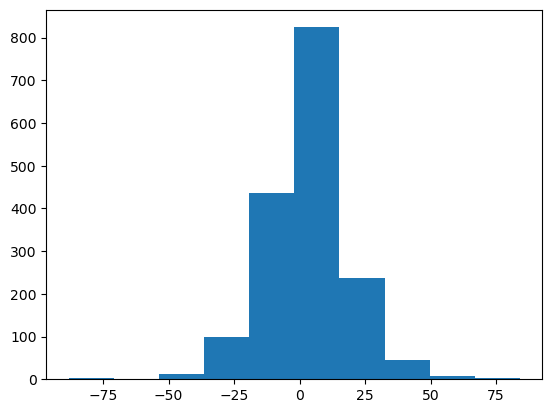

In [30]:
plt.hist(group_one.iloc[:,5])

(array([1.0000e+00, 2.0000e+00, 1.0000e+01, 1.5700e+02, 9.4300e+03,
        1.0827e+04, 1.3700e+02, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-212. , -169.4, -126.8,  -84.2,  -41.6,    1. ,   43.6,   86.2,
         128.8,  171.4,  214. ]),
 <BarContainer object of 10 artists>)

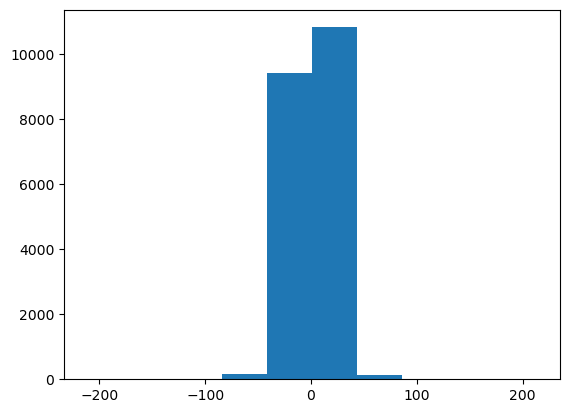

In [31]:
plt.hist(group_zero.iloc[:,5])

(array([  1.,   4.,  36., 139., 524., 799., 320.,  79.,  12.,   4.]),
 array([-142. , -114.6,  -87.2,  -59.8,  -32.4,   -5. ,   22.4,   49.8,
          77.2,  104.6,  132. ]),
 <BarContainer object of 10 artists>)

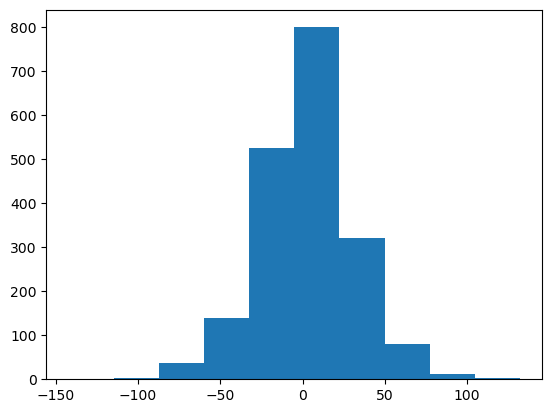

In [32]:
plt.hist(group_one.iloc[:,3])

(array([1.4000e+01, 1.8500e+02, 1.4650e+03, 6.9810e+03, 1.0925e+04,
        4.4900e+03, 8.4100e+02, 1.5200e+02, 3.3000e+01, 5.0000e+00]),
 array([-118. ,  -90.4,  -62.8,  -35.2,   -7.6,   20. ,   47.6,   75.2,
         102.8,  130.4,  158. ]),
 <BarContainer object of 10 artists>)

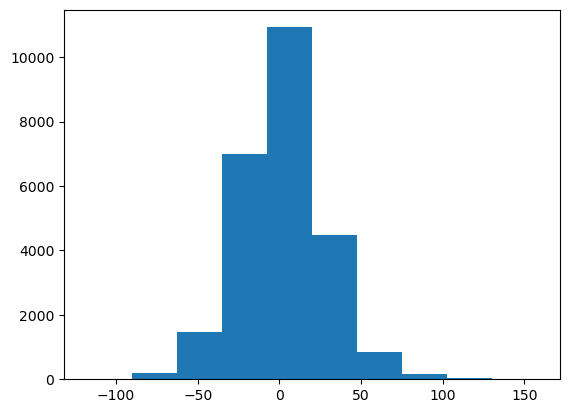

In [33]:
plt.hist(group_zero.iloc[:,3])

Performing two tailed T test for each feature with respect to the outcome

In [34]:
from scipy import stats as st

In [35]:
t_value=[]
p_value=[]
for i in group_zero.columns:
    tt, pp = st.ttest_ind(group_zero.dropna()[i], group_one.dropna()[i])
    t_value.append(tt)
    p_value.append(pp)

C:\Users\User\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Creating a dataframe containing the t test value and corresponding p value for all features (Note: the last row in the dataframe can be ignored as it is t test of sepsis label w.r.t sepsis label , hence infinity)

In [36]:
data_of_ttest = {'feature_name': group_zero.columns,
        't_value': t_value,
        'p_value': p_value}

In [37]:
data_ttest = pd.DataFrame(data_of_ttest)

In [38]:
data_ttest

,feature_name,t_value,p_value
0,HR,1.146556,0.303454
1,O2Sat,0.133215,0.899219
2,Temp,2.347340,0.065777
3,SBP,1.259311,0.263506
4,MAP,0.599678,0.574859
5,DBP,0.717466,0.505199
6,Resp,1.513182,0.190648
7,EtCO2,1.645216,0.160845
8,BaseExcess,1.022787,0.353319
9,HCO3,0.991982,0.366754


The mean is considered significantly different if the test statistic is in the top 2.5% or bottom 2.5% of its probability distribution, resulting in a p-value less than 0.05.
According to the result of t test, seems like there is significant difference in the mean of both groups (sepsis =0 and sepsis = 1) for features like alkaline phosphate, Hct, Hgb. There are other high t test values as well but the p values are not less than or equal to 0.05 

In [39]:
X = merged_group.iloc[:, 0:38]
X.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS
Patient_id,,,,,,,,,,,,,,,,,,,,,
p000001,13.0,10.0,-0.22,20.0,31.33,NaN,1.0,NaN,5.0,-3.0,...,1.0,0.3,NaN,-9.0,NaN,-21.0,83.14,0,-0.03,54
p000002,6.0,4.0,0.33,10.0,14.00,7.0,6.5,NaN,NaN,0.0,...,0.0,0.0,NaN,0.0,NaN,0.0,75.91,0,-98.60,23
p000003,9.0,-1.0,0.00,-7.0,-12.67,-3.0,3.0,NaN,3.0,3.0,...,-5.2,-1.9,1.0,1.3,NaN,2.0,45.82,0,-1195.71,48
p000007,52.5,-2.0,-0.11,39.5,25.00,20.0,16.0,NaN,-3.0,-7.0,...,8.3,1.3,-0.5,0.5,NaN,-17.0,64.24,1,-0.05,45
p000008,-11.0,4.0,-0.11,-36.0,-14.00,-3.5,1.5,NaN,-2.0,-1.0,...,7.9,2.8,NaN,2.0,NaN,152.0,87.08,1,-2.23,40


In [40]:
import seaborn as sns

C:\Users\User\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

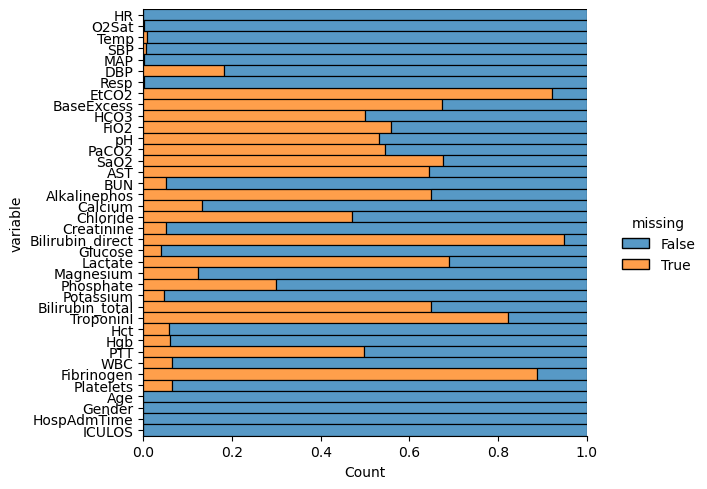

In [41]:
plt.figure(figsize=(10,6))
sns.displot(
    data= X.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25,
    #print(y)
)

There are many features with more than 60% missingness which are dropped

In [42]:
cols = X.columns[X.isna().mean()>0.6]
X = X.drop(cols, axis=1)

In [43]:
X.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'HCO3', 'FiO2',
       'pH', 'PaCO2', 'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Glucose',
       'Magnesium', 'Phosphate', 'Potassium', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS'],
      dtype='object')

In [44]:
X.shape

(27186, 28)

Ideally, we should impute on split data to avoid data leakage but, knn imputation in a cross validation after split requires a lot of computational power. Due to the low computational power of local machines, this approach could not be implemented.  After knn imputation, the data was split into train and test using stratification.


In [45]:
# imputing using knn
from sklearn.impute import KNNImputer

In [46]:
column_names = X.columns

In [47]:
X_knn = X.copy()

In [48]:
X_knn.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,pH,...,Potassium,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS
Patient_id,,,,,,,,,,,,,,,,,,,,,
p000001,13.0,10.0,-0.22,20.0,31.33,NaN,1.0,-3.0,0.03,0.04,...,-0.8,1.0,0.3,NaN,-9.0,-21.0,83.14,0,-0.03,54
p000002,6.0,4.0,0.33,10.0,14.00,7.0,6.5,0.0,NaN,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,75.91,0,-98.60,23
p000003,9.0,-1.0,0.00,-7.0,-12.67,-3.0,3.0,3.0,-0.30,0.02,...,-0.3,-5.2,-1.9,1.0,1.3,2.0,45.82,0,-1195.71,48
p000007,52.5,-2.0,-0.11,39.5,25.00,20.0,16.0,-7.0,0.60,-0.11,...,1.7,8.3,1.3,-0.5,0.5,-17.0,64.24,1,-0.05,45
p000008,-11.0,4.0,-0.11,-36.0,-14.00,-3.5,1.5,-1.0,NaN,-0.09,...,-1.2,7.9,2.8,NaN,2.0,152.0,87.08,1,-2.23,40


 knn imputation should have been done with a range of numbers for k (2,3,5,6) but due to limited time, only k=2 was carried out

In [49]:
imputer = KNNImputer(n_neighbors = 2)
X_knn_imputed = pd.DataFrame(imputer.fit_transform(X_knn), columns = column_names)
X_knn_imputed.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,pH,...,Potassium,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS
0,13.0,10.0,-0.22,20.0,31.33,26.5,1.0,-3.0,0.03,0.04,...,-0.8,1.0,0.3,24.9,-9.0,-21.0,83.14,0.0,-0.03,54.0
1,6.0,4.0,0.33,10.0,14.00,7.0,6.5,0.0,0.00,-0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,75.91,0.0,-98.60,23.0
2,9.0,-1.0,0.00,-7.0,-12.67,-3.0,3.0,3.0,-0.30,0.02,...,-0.3,-5.2,-1.9,1.0,1.3,2.0,45.82,0.0,-1195.71,48.0
3,52.5,-2.0,-0.11,39.5,25.00,20.0,16.0,-7.0,0.60,-0.11,...,1.7,8.3,1.3,-0.5,0.5,-17.0,64.24,1.0,-0.05,45.0
4,-11.0,4.0,-0.11,-36.0,-14.00,-3.5,1.5,-1.0,-0.25,-0.09,...,-1.2,7.9,2.8,19.7,2.0,152.0,87.08,1.0,-2.23,40.0


In [50]:
merged_group['SepsisLabel'].isnull().values.any()

False

In [51]:
y = merged_group.iloc[:, 38]

Class imbalance shown by pie chart (negatives / positives = 12)

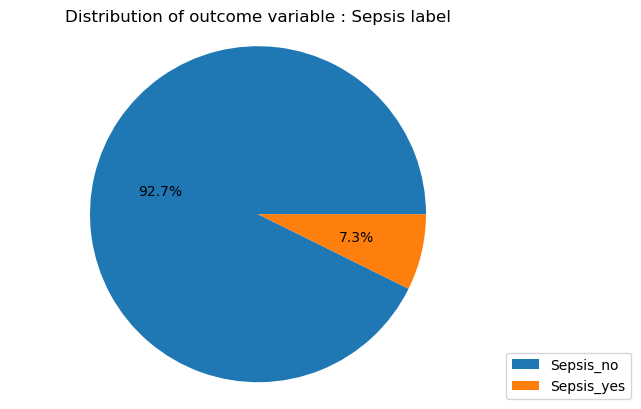

In [52]:
labels = ['Sepsis_no', 'Sepsis_yes']
sizes = y.value_counts()
pie = plt.pie(sizes, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of outcome variable : Sepsis label')
plt.legend(loc = (1,0), labels=labels)
plt.show()

In [53]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_knn_imputed, y, test_size=0.2, stratify=y, random_state=42)

In [54]:
y_train.size

21748

In [55]:
y_test.size

5438

Model used XGBoost classifier
Hyperparameter tuning:  Hyperparameters considered for tuning were max_depth (control the depth of tree and hence overfitting, n_estimators, learning rate and weighted class. For weighted class, ratio of negative to positives was used as weight and also its square root which is recommended for highly imbalanced data. Therefore weight 12 and square root of 12 were used. The best parameters and best model was obtained from grid search cv (5 folds 3 repeats). Would have been ideal to have more weights and more repeats but could not carry out due to low computational power.

In [56]:
model = XGBClassifier(objective= 'binary:logistic')

In [57]:
params = {'max_depth': [2,5,7,10], 'n_estimators': [50, 100, 250],'learning_rate': [0.1, 0.05, 0.01], 
              'scale_pos_weight':[11, 12, 3.5]}

In [58]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
grid = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring='roc_auc')

In [61]:
grid_result_1 = grid.fit(x_train, y_train)

In [62]:
best_score1 = grid_result_1.best_score_
best_params1 = grid_result_1.best_params_
best_model1 = grid_result_1.best_estimator_

In [63]:
best_score1

0.890915663315491

In [64]:
best_params1

{'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 250,
 'scale_pos_weight': 3.5}

In [65]:
# save the model
import pickle
filename = 'ml_weighted_classes_model.sav'
pickle.dump(best_model1, open(filename, 'wb'))

In [66]:
predict1 = best_model1.predict(x_test)

In [67]:
predict1

array([0, 0, 0, ..., 0, 1, 0])

In [70]:
from sklearn.metrics import confusion_matrix, classification_report

In [71]:
cm1 = confusion_matrix(y_test, predict1)
print(cm1)

[[4910  130]
 [ 165  233]]


In [72]:
classification_report1 = classification_report(y_test, predict1)
print(classification_report1)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5040
           1       0.64      0.59      0.61       398

    accuracy                           0.95      5438
   macro avg       0.80      0.78      0.79      5438
weighted avg       0.94      0.95      0.94      5438



In [73]:
from sklearn import metrics

In [74]:
from sklearn.metrics import RocCurveDisplay

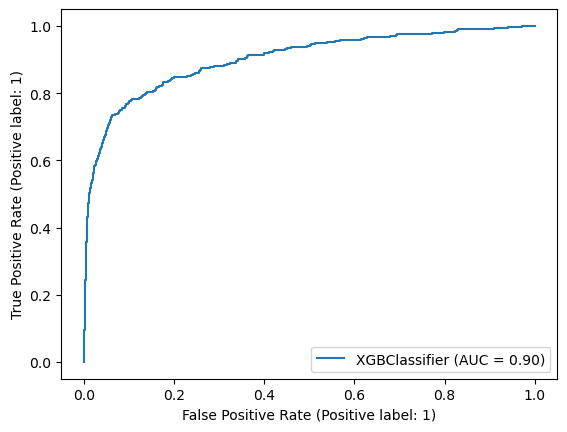

In [75]:
RocCurveDisplay.from_estimator(best_model1, x_test, y_test)

In [77]:
import shap

In [78]:
shap.initjs()

Global interepretibility

[02:54:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


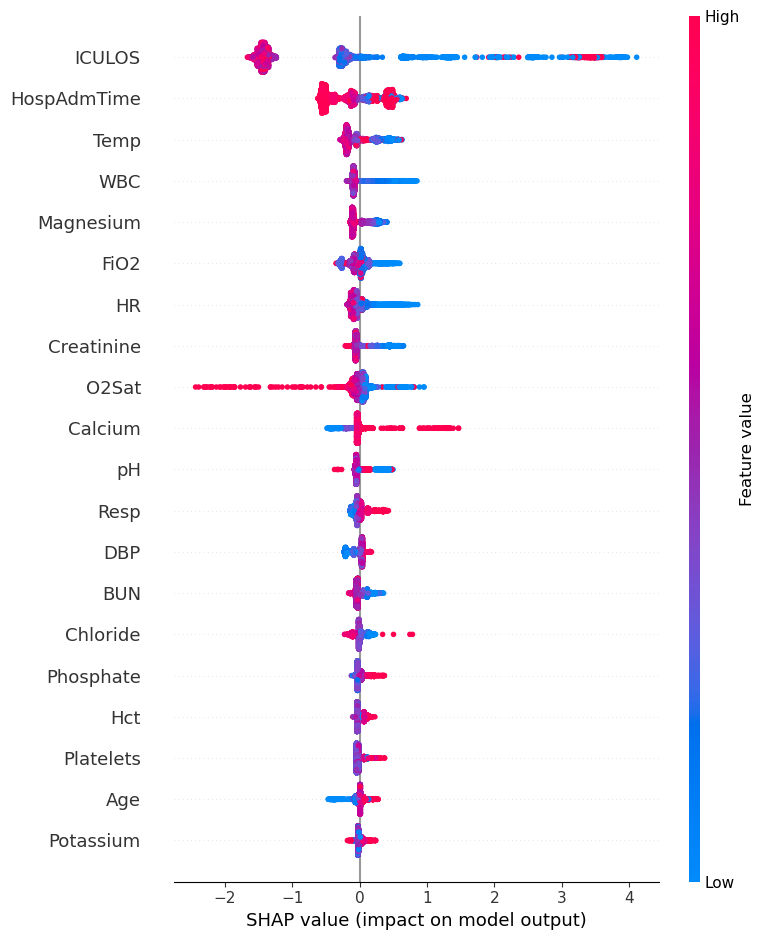

In [79]:
explainer_weighted = shap.TreeExplainer(best_model1)
shap_values_weighted = explainer_weighted.shap_values(x_test)
shap.summary_plot(shap_values_weighted, x_test)

local interpretibility

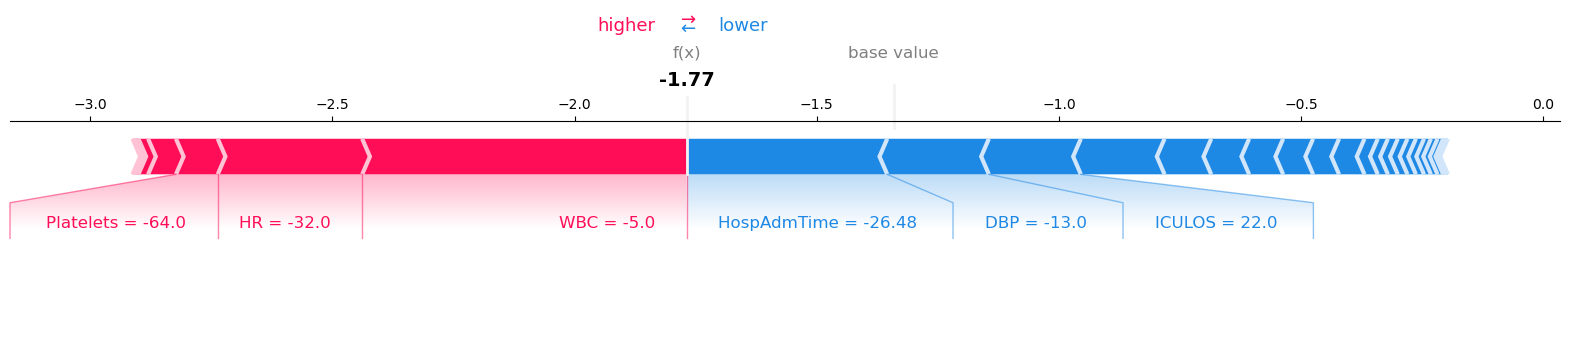

In [81]:
shap.force_plot(explainer_weighted.expected_value, shap_values_weighted[10], features=x_test.iloc[10], feature_names=x_test.columns, matplotlib=True)

In above example, O2sat, HR and WBC have higher impact on the prediction and other in blue have low impact

It is observed that this model gives AUC of 0.9, f1-score of 0.97 for the 'Sepsis_no' class and f1-score of 0.61 for the 'Sepsis-yes' class. Other data imbalance handling methods like random undersampling, random oversampling and SMOTE should be tried which were not carried out in this project due to time constraints. This model shows that vital signs and laboratory tests can be used for sepsis diagnosis.